<a href="https://colab.research.google.com/github/RishikeshMagar/ColabBoltz/blob/main/examples/ColabBoltz_Monomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab Notebook to run Boltz-2.

In [ ]:
#@title Install dependencies

!pip install -q boltz -U
!pip install -q py3Dmol rdkit biopython matplotlib pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
# !boltz --help

Following the [ColabFold Protocols](https://www.nature.com/articles/s41596-024-01060-5), we explore monomer Prediction in this example notebook. I will be using the [PIGU](https://github.com/steineggerlab/colabfold-protocol/blob/main/query/PIGU.fasta) fasta sequence as an example

In [ ]:
#@title Input protein and ligand(s)
from google.colab import files
import os
import re
import hashlib
import random
import requests

# Helper to generate unique job name
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown ### Protein(s)
query_sequence = 'MAAPLVLVLVVAVTVRAALFRSSLAEFISERVEVVSPLSSWKRVVEGLSLLDLGVSPYSGAVFHETPLIIYLFHFLIDYAELVFMITDALTAIALYFAIQDFNKVVFKKQKLLLELDQYAPDVAELIRTPMEMRYIPLKVALFYLLNPYTILSCVAKSTCAINNTLIAFFILTTIKGSAFLSAIFLALATYQSLYPLTLFVPGLLYLLQRQYIPVKMKSKAFWIFSWEYAMMYVGSLVVIICLSFFLLSSWDFIPAVYGFILSVPDLTPNIGLFWYFFAEMFEHFSLFFVCVFQINVFFYTIPLAIKLKEHPIFFMFIQIAVIAIFKSYPTVGDVALYMAFFPVWNHLYRFLRNIFVLTCIIIVCSLLFPVLWHLWIYAGSANSNFFYAITLTFNVGQILLISDYFYAFLRREYYLTHGL'  #@param {type:"string"}
#@markdown Use `:` to separate chains (e.g., "SEQ1:SEQ2")

#@markdown ### Ligands
ligand_input = ''  #@param {type:"string"}
#@markdown - Colon-separated SMILES strings

ligand_input_ccd = ''  #@param {type:"string"}
#@markdown - Colon-separated CCD codes

ligand_input_common_name = ''  #@param {type:"string"}
#@markdown - Colon-separated common names (e.g., "aspirin")

#@markdown ### DNA
dna_input = ''  #@param {type:"string"}
#@markdown - Colon-separated DNA sequences

rna_input = ''  #@param {type:"string"}
#@markdown - Colon-separated RNA sequences

#@markdown ### Jobname
jobname = 'Monomer Prediction'  #@param {type:"string"}

# Clean up
query_sequence = "".join(query_sequence.split())
ligand_input = "".join(ligand_input.split())
ligand_input_ccd = "".join(ligand_input_ccd.split())
ligand_input_common_name = "".join(ligand_input_common_name.split())
dna_input = "".join(dna_input.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# Ensure uniqueness
if os.path.exists(jobname):
    n = 0
    while os.path.exists(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# Create job folder
os.makedirs(jobname, exist_ok=True)
print(f"✅ Job directory created: {jobname}")


✅ Job directory created: MonomerPrediction_36762


In [ ]:
#@title ### MSA Options and Setup
from google.colab import files
import os
import fileinput

#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs_server" #@param ["mmseqs_server", "single_sequence", "custom"]
msa_pairing_strategy = "greedy"   #@param ["greedy", "complete", "unpaired"]

# Determine MSA file based on mode
if msa_mode == "mmseqs_server":
    a3m_file = None

elif msa_mode == "custom":
    a3m_file = os.path.join(jobname, f"{jobname}.custom.a3m")
    if not os.path.isfile(a3m_file):
        print("📥 Please upload your custom MSA file (.a3m)")
        uploaded = files.upload()
        custom_msa = list(uploaded.keys())[0]

        # Extract the first query sequence
        header_count = 0
        for line in fileinput.FileInput(custom_msa, inplace=True):
            if line.startswith(">"):
                header_count += 1
            if not line.strip():
                continue
            if not line.startswith(">") and header_count == 1:
                query_sequence = line.strip()
            print(line, end='')

        os.rename(custom_msa, a3m_file)
        print(f"✅ MSA saved to {a3m_file}")

else:  # single_sequence
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as f:
        f.write(">1\n" + query_sequence)
    print(f"✅ Single sequence MSA written to {a3m_file}")


In [ ]:
#@title Process inputs and write YAML
import os
import yaml
from string import ascii_uppercase

# Step 1: Split sequences on chain breaks
protein_sequences = query_sequence.strip().split(':') if query_sequence.strip() else []
ligand_sequences = ligand_input.strip().split(':') if ligand_input.strip() else []
ligand_sequences_ccd = ligand_input_ccd.strip().split(':') if ligand_input_ccd.strip() else []
ligand_sequences_common_name = ligand_input_common_name.strip().split(':') if ligand_input_common_name.strip() else []
dna_sequences = dna_input.strip().split(':') if dna_input.strip() else []
rna_sequences = rna_input.strip().split(':') if rna_input.strip() else []

msa_mode  = msa_mode.strip().lower()

# #@markdown ### output_jobname
# output_jobname = 'PIGU'  #@param {type:"string"}

# Step 2: Resolve common names to SMILES
def get_smiles(compound_name):
    autocomplete_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/autocomplete/compound/{compound_name}/json?limit=1"
    autocomplete_response = requests.get(autocomplete_url)
    if autocomplete_response.status_code != 200:
        return None
    autocomplete_data = autocomplete_response.json()
    if autocomplete_data.get("status", {}).get("code") != 0 or autocomplete_data.get("total", 0) == 0:
        return None
    suggested = autocomplete_data.get("dictionary_terms", {}).get("compound", [])
    if not suggested:
        return None
    smiles_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{suggested[0]}/property/CanonicalSMILES/JSON"
    smiles_response = requests.get(smiles_url)
    if smiles_response.status_code != 200:
        return None
    props = smiles_response.json().get("PropertyTable", {}).get("Properties", [])
    return props[0].get("CanonicalSMILES") if props else None

smiles_cache = {}
for name in ligand_sequences_common_name:
    if name not in smiles_cache:
        smiles_cache[name] = get_smiles(name)
        if smiles_cache[name]:
            print(f"Mapped compound {name} to {smiles_cache[name]}")
    if smiles_cache[name]:
        ligand_sequences.append(smiles_cache[name])

# Step 3: Assign chain labels and collect entries
chain_labels = iter(ascii_uppercase)
sequences_yaml = []
csv_entries = []
seq_id_counter = 0
seq_to_seq_id = {}

for seq in protein_sequences:
    seq = seq.strip()
    if not seq:
        continue
    chain_id = next(chain_labels)
    if seq not in seq_to_seq_id:
        seq_id = f"{jobname}_{seq_id_counter}"
        seq_id_counter += 1
        seq_to_seq_id[seq] = seq_id
        csv_entries.append((seq_id, seq))

    if msa_mode == "single_sequence":
        msa_path = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
        sequences_yaml.append({
            "protein": {
                "id": chain_id,
                "sequence": seq,
                "msa": msa_path

            }
        })
    elif msa_mode == "custom":
        msa_path = os.path.join(jobname, f"{jobname}.custom.a3m")
        sequences_yaml.append({
            "protein": {
                "id": chain_id,
                "sequence": seq,
                "msa": msa_path
            }
        })
    else:
        sequences_yaml.append({
            "protein": {
                "id": chain_id,
                "sequence": seq,
            }
        })

for smiles in ligand_sequences:
    smiles = smiles.strip()
    if not smiles:
        continue
    chain_id = next(chain_labels)
    sequences_yaml.append({
        "ligand": {
            "id": chain_id,
            "smiles": smiles
        }
    })

for ccd in ligand_sequences_ccd:
    ccd = ccd.strip().upper()
    if not ccd:
        continue
    chain_id = next(chain_labels)
    sequences_yaml.append({
        "ligand": {
            "id": chain_id,
            "ccd": ccd
        }
    })

for dna in dna_sequences:
    dna = dna.strip()
    if not dna:
        continue
    chain_id = next(chain_labels)
    sequences_yaml.append({
        "dna": {
            "id": chain_id,
            "sequence": dna
        }
    })

# Step 4: Write CSV for MSA (ColabFold)
csv_path = os.path.join(jobname, f"{jobname}.csv")
with open(csv_path, 'w') as f:
    f.write("id,sequence\n")
    for seq_id, seq in csv_entries:
        f.write(f"{seq_id},{seq}\n")

# Step 5: Write YAML for Boltz
yaml_path = os.path.join(jobname, f"{jobname}.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump({"sequences": sequences_yaml}, f, sort_keys=False)

print(f"✅ YAML written to: {yaml_path}")
print(f"✅ CSV written to: {csv_path}")


✅ YAML written to: MonomerPrediction_36762/input.yaml
✅ CSV written to: MonomerPrediction_36762/MonomerPrediction_36762.csv


In [ ]:
#@title Boltz Runtime Settings
#@markdown These will be passed as CLI flags to `boltz predict`

# General
out_dir = "results"  #@param {type:"string"}
cache_dir = "~/.boltz"  #@param {type:"string"}
checkpoint = ""  #@param {type:"string"}
devices = 1  #@param {type:"integer"}
accelerator = "gpu"  #@param ["gpu", "cpu", "tpu"]
num_workers = 2  #@param {type:"integer"}
output_format = "mmcif"  #@param ["pdb", "mmcif"]

# Sampling
sampling_steps = 200  #@param {type:"integer"}
diffusion_samples = 5  #@param {type:"integer"}
max_parallel_samples = 5  #@param {type:"integer"}
step_scale = 1.638  #@param {type:"number"}

# MSA
if msa_mode == "mmseqs_server":
    use_msa_server = True
    msa_server_url = "https://api.colabfold.com"  #@param {type:"string"}
else:
    use_msa_server = False
# use_msa_server = True  #@param {type:"boolean"}
# msa_server_url = "https://api.colabfold.com"  #@param {type:"string"}
# msa_pairing_strategy = "greedy"  #@param ["greedy", "complete"]
max_msa_seqs = 8192  #@param {type:"integer"}
subsample_msa = False  #@param {type:"boolean"}
num_subsampled_msa = 1024  #@param {type:"integer"}

# Affinity settings (optional, for protein-ligand tasks later)
affinity_checkpoint = ""  #@param {type:"string"}
sampling_steps_affinity = 200  #@param {type:"integer"}
diffusion_samples_affinity = 5  #@param {type:"integer"}
affinity_mw_correction = False  #@param {type:"boolean"}

# Preprocessing and advanced flags
method = ""  #@param {type:"string"}
preprocessing_threads = 4  #@param {type:"integer"}
no_trifast = False  #@param {type:"boolean"}
override = False  #@param {type:"boolean"}
use_potentials = False  #@param {type:"boolean"}
write_full_pae = False  #@param {type:"boolean"}
write_full_pde = False  #@param {type:"boolean"}

# # For reproducibility
# random_seed = 42  #@param {type:"integer"}

print("✅ All runtime flags captured.")




✅ All runtime flags captured.


In [ ]:
import shlex

# Required args
yaml_path = f"{jobname}/input.yaml"
output_dir = jobname

# CLI defaults based on Boltz documentation
defaults = {
    "sampling_steps": 200,
    "diffusion_samples": 1,
    "seed": None,
    "device": "",  # empty means auto
    "use_msa_server": False,
    "msa_server_url": "https://api.colabfold.com",
    "msa_pairing_strategy": "greedy",
    "max_parallel_samples": 5,
    "step_scale": 1.638,
    "output_format": "mmcif",
    "num_workers": 2,
    "max_msa_seqs": 8192,
    "subsample_msa": False,
    "num_subsampled_msa": 1024,
    "no_trifast": False,
    "override": False,
    "use_potentials": False,
    "write_full_pae": False,
    "write_full_pde": False,
    "checkpoint": "",
    "cache_dir": "~/.boltz",
    "devices": 1,
    "accelerator": "gpu",
    "preprocessing-threads": None,
    "method": "",
    "affinity_checkpoint": "",
    "sampling_steps_affinity": 200,
    "diffusion_samples_affinity": 5,
    "affinity_mw_correction": False,
}
# User-specified values (names match your param block exactly)
# User-specified values (names match your @param block exactly)
flags = {
    "sampling_steps": sampling_steps,
    "diffusion_samples": diffusion_samples,
    "use_msa_server": use_msa_server,
    "msa_server_url": msa_server_url,
    "msa_pairing_strategy": msa_pairing_strategy,
    "max_parallel_samples": max_parallel_samples,
    "step_scale": step_scale,
    "output_format": output_format,
    "num_workers": num_workers,
    "max_msa_seqs": max_msa_seqs,
    "subsample_msa": subsample_msa,
    "num_subsampled_msa": num_subsampled_msa,
    "no_trifast": no_trifast,
    "override": override,
    "use_potentials": use_potentials,
    "write_full_pae": write_full_pae,
    "write_full_pde": write_full_pde,
    "checkpoint": checkpoint,
    "cache_dir": cache_dir,
    "devices": devices,
    "accelerator": accelerator,
    "preprocessing-threads": preprocessing_threads,
    "method": method,
    "affinity_checkpoint": affinity_checkpoint,
    "sampling_steps_affinity": sampling_steps_affinity,
    "diffusion_samples_affinity": diffusion_samples_affinity,
    "affinity_mw_correction": affinity_mw_correction,
}


# Build command
cmd = ["boltz", "predict", "--out_dir", output_dir]

for k, v in flags.items():
    default = defaults[k]
    if v != default and v is not None and v != "":
        flag = f"--{k}"
        if isinstance(v, bool):
            if v:
                cmd.append(flag)
        else:
            cmd += [flag, str(v)]

# Positional YAML file argument
cmd.append(yaml_path)

# Print full command
print("✅ Running command:\n", " ".join(shlex.quote(arg) for arg in cmd))

# Execute
!{" ".join(shlex.quote(arg) for arg in cmd)}

✅ Running command:
 boltz predict --out_dir MonomerPrediction_36762 --diffusion_samples 5 --use_msa_server --preprocessing-threads 4 MonomerPrediction_36762/input.yaml
Checking input data.
Processing 1 inputs with 1 threads.
  0% 0/1 [00:00<?, ?it/s]Generating MSA for MonomerPrediction_36762/input.yaml with 1 protein entities.

  0% 0/150 [00:00<?, ?it/s]
SUBMIT:   0% 0/150 [00:00<?, ?it/s]
COMPLETE:   0% 0/150 [00:00<?, ?it/s]
COMPLETE: 100% 150/150 [00:01<00:00, 115.17it/s]
100% 1/1 [00:01<00:00,  1.80s/it]
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running structure prediction for 1 input.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.5.0
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Ten

In [ ]:
import numpy as np

plddt = np.load(f"{jobname}/boltz_results_input/predictions/input/plddt_input_model_0.npz")
pae   = np.load(f"{jobname}/boltz_results_input/predictions/input/pae_input_model_0.npz")
pde   = np.load(f"{jobname}/boltz_results_input/predictions/input/pde_input_model_0.npz")
print(plddt.files)
print(plddt[plddt.files[0]].shape)

print(pae.files)
print(pae[pae.files[0]].shape)

print(pde.files)
print(pde[pde.files[0]].shape)


['plddt']
(420,)
['pae']
(420, 420)
['pde']
(420, 420)


In [ ]:
str1 = "MAAPLVLVLVVAVTVRAALFRSSLAEFISERVEVVSPLSSWKRVVEGLSLLDLGVSPYSGAVFHETPLIIYLFHFLIDYAELVFMITDALTAIALYFAIQDFNKVVFKKQKLLLELDQYAPDVAELIRTPMEMRYIPLKVALFYLLNPYTILSCVAKSTCAINNTLIAFFILTTIKGSAFLSAIFLALATYQSLYPLTLFVPGLLYLLQRQYIPVKMKSKAFWIFSWEYAMMYVGSLVVIICLSFFLLSSWDFIPAVYGFILSVPDLTPNIGLFWYFFAEMFEHFSLFFVCVFQINVFFYTIPLAIKLKEHPIFFMFIQIAVIAIFKSYPTVGDVALYMAFFPVWNHLYRFLRNIFVLTCIIIVCSLLFPVLWHLWIYAGSANSNFFYAITLTFNVGQILLISDYFYAFLRREYYLTHGL"

In [ ]:
len(str1)

420

In [ ]:
#@title View Boltz-predicted CIF structure (basic cartoon)
import py3Dmol
import os

# Path to CIF file
cif_path = f"{jobname}/boltz_results_input/predictions/input/input_model_0.cif"


if not os.path.isfile(cif_path):
    raise FileNotFoundError(f"No CIF found at {cif_path}")

# Load and display
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
with open(cif_path, 'r') as f:
    cif_data = f.read()

view.addModel(cif_data, 'cif')
view.setStyle({'cartoon': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title View CIF structure colored by pLDDT

import py3Dmol
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#@markdown Select a coloring scheme:
coloring_mode = "plddt"  #@param ["plddt", "uniform", "chain", "rainbow"]
show_sidechains = False  #@param {type:"boolean"}

structure_index = 0  #@param {type:"integer"}
# Load CIF and pLDDT
cif_path = f"{jobname}/boltz_results_input/predictions/input/input_model_{structure_index}.cif"
plddt_path = f"{jobname}/boltz_results_input/predictions/input/plddt_input_model_{structure_index}.npz"
plddt_scaled = np.load(plddt_path)['plddt']

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(cif_path).read(), 'cif')

if coloring_mode == "plddt":
    # Color by pLDDT score using RdYlGn
    norm = mcolors.Normalize(vmin=0.1, vmax=1)
    cmap = cm.get_cmap("RdYlGn")
    colors = [mcolors.to_hex(cmap(norm(score))) for score in plddt_scaled]
    for i, color in enumerate(colors):
        view.setStyle({'resi': str(i + 1)}, {'cartoon': {'color': color}})

elif coloring_mode == "uniform":
    view.setStyle({'cartoon': {'color': '#66C2A5'}})  # Mint green

elif coloring_mode == "chain":
    color_list = ['#66C2A5', '#8DA0CB', '#FC8D62', '#E78AC3', '#A6D854']
    from string import ascii_uppercase
    for i, chain in enumerate(ascii_uppercase):
        view.setStyle({'chain': chain}, {'cartoon': {'color': color_list[i % len(color_list)]}})

elif coloring_mode == "rainbow":
    view.setStyle({'cartoon': {'color': 'spectrum'}})

# Optional: sidechains
if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':"WhiteCarbon",'radius':0.3}})

view.zoomTo()
view.show()



<ipython-input-21-2554966682>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

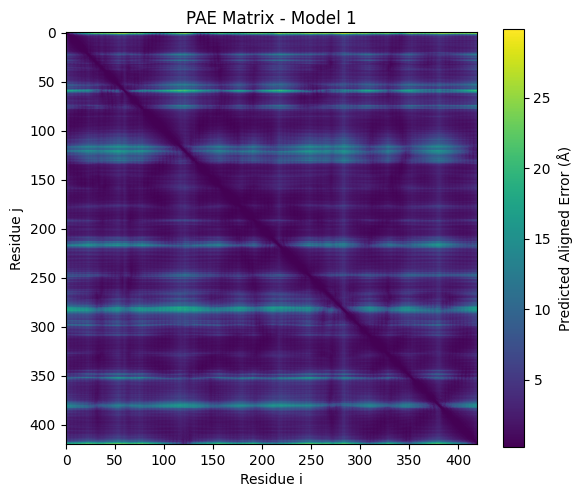

In [ ]:
#@title Plot PAE matrix for selected model {run: "auto"}
import numpy as np
import matplotlib.pyplot as plt
import os

#@markdown Select structure index (must match selected structure)
structure_index = 1  #@param {type:"integer"}

# Load PAE matrix from npz
pae_path = f"{jobname}/boltz_results_input/predictions/input/pae_input_model_{structure_index}.npz"
if not os.path.isfile(pae_path):
    raise FileNotFoundError(f"PAE file not found: {pae_path}")

pae_matrix = np.load(pae_path)['pae']

# Plot PAE heatmap
plt.figure(figsize=(6, 5))
plt.imshow(pae_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Predicted Aligned Error (Å)")
plt.title(f"PAE Matrix - Model {structure_index}")
plt.xlabel("Residue i")
plt.ylabel("Residue j")
plt.tight_layout()
plt.show()


In [ ]:
if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")